<a href="https://colab.research.google.com/github/hamzajb95/CE888/blob/main/Project/HateSpeechClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install transformers

In [ ]:
!nvidia-smi

Wed Apr 28 22:34:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import transformers as ppb
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
import collections
from sklearn.metrics import confusion_matrix,classification_report
import pprint
from transformers import AutoModel, AutoTokenizer









In [ ]:
device = torch.device(type='cuda', index=0)

In [ ]:
pd.set_option('display.max_colwidth', None)

#Importing data for emotion dataset
url_mapping = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt'
url_trainText = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt'
url_trainLabel = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt'
url_testText = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt'
url_testLabel = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt'

hate_list = [url_mapping,url_trainText,url_trainLabel,url_testText,url_testLabel]

In [ ]:
#You pass the url to the function and you are returned a list
def getText(url):
    response = urllib.request.urlopen(url)
    Text = response.read()
    Text=Text.decode("utf-8")
    lines = Text.split('\n')
    return lines[:]

In [ ]:
#Removes @users tags from the tweets and return the train and test data
def preProcess(urlList):
  mapping = getText(urlList[0])
  train_text = getText(urlList[1])[:-1]
  train_labels = getText(urlList[2])[:-1]
  test_text = getText(urlList[3])[:-1]
  test_labels = getText(urlList[4])[:-1]

  #Turn those train and test lists into Dataframes.
  df=pd.DataFrame({"tweet":train_text,"label":train_labels}) #change name to df_train
  df_test = pd.DataFrame({"tweet":test_text, "label":test_labels})

  

  #We are now going to remove the @user tags from tweets for both train and test sets.
  df['tweet']=df['tweet'].apply(lambda x: re.sub('@user','', x))
  df_test['tweet']=df_test['tweet'].apply(lambda x: re.sub('@user','', x))

  print(mapping)
  
  return df, df_test, mapping

In [ ]:
hate_data = preProcess(hate_list)
hate_train = hate_data[0]
hate_test = hate_data[1]
hate_train


['0\tnot-hate', '1\thate']


,tweet,label
0,nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…,0
1,A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎,1
2,real talk do you have eyes or were they gouged out by a rapefugee?,1
3,your girlfriend lookin at me like a groupie in this bitch!,1
4,Hysterical woman like,0
...,...,...
8995,Oooohhhh bitch didn't even listen to the dead kennedys what a cunt lol I'm 34 and hate rap,0
8996,Good Luck More Americans #WalkAwayFromDemocrat #WallkAway from OPEN BORDERS Pro illegal #Immigration Anti American Agenda #RedNationRising via,0
8997,Bitch you can't keep up so stop trying,1
8998,Japan is always operating under the premise that mass migration that can radically transform the country's demographics is unacceptable. The Alt-Right main point is the n,0


In [ ]:
label_names = ['not-hate','hate']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Label Count Train Set')

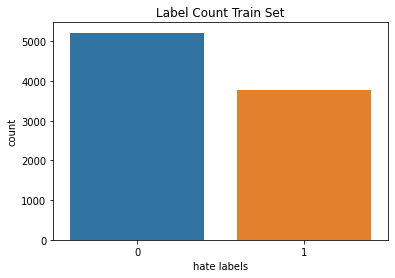

In [ ]:
sns.countplot(hate_train.label)
plt.xlabel('hate labels');
plt.title("Label Count Train Set")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Label Count Test Set')

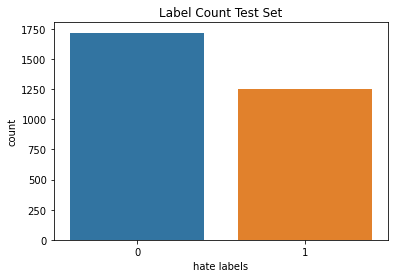

In [ ]:
sns.countplot(hate_test.label)
plt.xlabel('hate labels');
plt.title("Label Count Test Set")

In [ ]:
##  Lets create an Validation set as well from the training set
hate_train, hate_val = train_test_split(hate_train, test_size=0.2, random_state = 23, stratify=hate_train['label'])
hate_val



,tweet,label
5507,Crazy warminister von der Leyen thinks that weapons will bring peace in Mali or Niger and less refugees. Never weapons will bring peace.,0
1674,Feminists become radicalized when they refuse to submit to their urges to be subservient to men. It's science...,1
1490,What’s up bitch ass bitches and skank ass skanks,1
2254,U DAM STUPID ASS HOLE THEY DON'T KILL ANIMALS IT FOR WOMEN WITH BREAST CANCER U DAM BITCH!!!!,1
6117,"#Trump Compares Immigration in Japan, Other 'Successful' Countries To United States In TuckerÂ…",0
...,...,...
426,Church leaders determine to ease #economic problems at the heart of #humantrafficking plaguing #Indonesia,0
6826,"You constantly act like you havent done bad shit in the past when you CLEARLY have. You constantly pretend that youre a good person, but you constantly make threats towards other people and call Tevin an ape. Shut the fuck up, grow the fuck up, and take responsibility you cunt",0
7522,Some #immigrant children may never be re-united with their parents. The #Trump administration neither cares nor has the wherewithal to fix the problem that Trump created. The negligence is criminal.,0
1783,Back to the kitchen you stupid sandwich maker,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Label Count Validation Set')

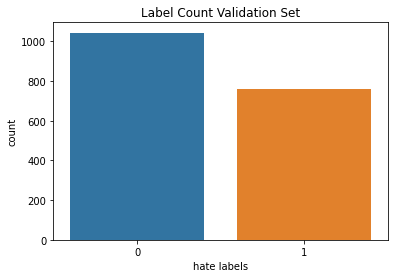

In [ ]:
sns.countplot(hate_val.label)
plt.xlabel('hate labels');
plt.title("Label Count Validation Set")

# Data Preprocessing


In [ ]:
#Lets call the Bert pretrained tokenizer and the Bert Model
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,use_fast=False)



emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
# def BertTok(df):

#   ### We need each list in tokenized to have the same length
#   ### We do this by first getting the tweet with the biggest length
#   ### and Padding the rest as per required to get each sentence to maxLen

#   maxLen = 0
#   for i in df.tweet.values:
#     if len(i) > maxLen:
#       maxLen = len(i)
      
#   print(maxLen)

#   #tokenize
#   tokenized = df['tweet'].apply((lambda x: tokenizer.encode_plus(x,
#                                                                  max_length = maxLen,
#                                                                  add_special_tokens=True,
#                                                                  return_token_type_ids = False,
#                                                                  pad_to_max_length=True,
#                                                                  return_attention_mask=True,
#                                                                  return_tensors='pt',
#                                                                  )))

#   print(tokenized[0])
  

#   #paded = np.array([i + [0]*(maxLen-len(i)) for i in tokenized.values])
#   #print(paded.shape) #So just to be clear the maxLen was 35 as that is not the length of each numpy array.

#   #We need to create another numpy array which gives 0 to ignore the mask and 1 to accept the Token
#   #attention_mask = np.where(paded != 0,1,0)


#   #print(attention_mask.shape)


In [ ]:
# emot_trainFeat = BertTok(emot_train)

### From torch import Dataset and create pytorch Dataset

In [ ]:
#We are going to turn the pandas dataframes into Pytorch Datasets using the
#TweetDataset class.
class TweetDataset(Dataset):
  ##Create constructor
  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  ##Mandatory function for length of dataset
  def  __len__(self):
    return len(self.tweets)

  ##Mandatory getter function to retrieve item
  def __getitem__(self,item):
    tweet = str(self.tweets[item])
    label = int(self.labels[item])

    ##Encoding function from transformers tokenizers with extra parameter settings to pad, return attention mask etc etc
    encoding = self.tokenizer.encode_plus(tweet,
                                    max_length = self.max_len,
                                    add_special_tokens=True,
                                    return_token_type_ids = False,
                                    pad_to_max_length=True,
                                    return_attention_mask=True,
                                    return_tensors='pt',
                          )
  
    ##Return the transformed input Ids and the attention mask along with tensored labels
    return {
        'tweet_text':tweet,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'labels':torch.tensor(label, dtype=torch.long)
    }


In [ ]:
hate_train.shape,hate_val.shape, hate_test.shape

((7200, 2), (1800, 2), (2970, 2))

### Now we create the Data Loader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
      tweets = df.tweet.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  
  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 2
  )


In [ ]:
MAX_LEN = 163
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
#Lets call the Bert pretrained tokenizer and the Bert Model
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, use_fast=False)

## Lets call the Data Loader for all of our datasets train,val,test
hate_train_dataload = create_data_loader(hate_train, tokenizer, MAX_LEN, BATCH_SIZE)
hate_val_dataload = create_data_loader(hate_val, tokenizer, MAX_LEN, BATCH_SIZE)
hate_test_dataload = create_data_loader(hate_test, tokenizer, MAX_LEN, BATCH_SIZE)


###Just checking the dataloaders

In [ ]:
data = next(iter(hate_train_dataload))
print(data.keys())
print(data['input_ids'][0])
print(data['attention_mask'].shape)
print(data['labels'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])
tensor([    0,   546,   680, 18119,    54,   333,     9,   115,    11, 21911,
        12830,    20,   160,   493,    16,     6,  4978,   629, 15346,    61,
        22594,   106,    35,     6,  3702,    30,    74, 26223,  1861,    13,
        11460,    87,    41, 19162,     9,  1481, 15795,     4,  2047,  2734,
          234, 18268,    30,    11,  2310,  8983, 16296,     4, 20177, 47460,
        50579,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     

###Now lets call the BERT model

In [ ]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p=0.3)
    self.out= nn.Linear(self.bert.config.hidden_size,n_classes)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(  #last_hidden_state is denoted as _ as we will not use it
    input_ids = input_ids,
    attention_mask = attention_mask
    )
    output=self.drop(pooled_output)
    output=self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifier(len(hate_data[2]))
model = model.to(device)

###Lets start with the training of the model

In [ ]:
## Just a test
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape,attention_mask.shape)
print(type(input_ids[0]))

torch.Size([16, 163]) torch.Size([16, 163])
<class 'torch.Tensor'>


In [ ]:
model(input_ids,attention_mask)

tensor([[0.4538, 0.5462],
        [0.5253, 0.4747],
        [0.4875, 0.5125],
        [0.4435, 0.5565],
        [0.4729, 0.5271],
        [0.4968, 0.5032],
        [0.4455, 0.5545],
        [0.4736, 0.5264],
        [0.4973, 0.5027],
        [0.4983, 0.5017],
        [0.5002, 0.4998],
        [0.5324, 0.4676],
        [0.4771, 0.5229],
        [0.4701, 0.5299],
        [0.4750, 0.5250],
        [0.4790, 0.5210]], device='cuda:0', grad_fn=<SoftmaxBackward>)

#Training 

In [ ]:
#In line with the paper that introduced BERT we are going to use the Adam algorithm with weight decay fix as our optimizer

optimizer = ppb.AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(hate_train_dataload)*EPOCHS


scheduler = ppb.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Helper function for training our model for one(each) EPOCH:

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  
  losses = []
  correct_pred = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _,preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_pred += torch.sum(preds==labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_pred.double()/n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_.

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_pred = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _,preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_pred += torch.sum(preds == labels)
    losses.append(loss.item())
  return correct_pred.double() / n_examples, np.mean(losses)

Using the above 2 helper functions and the declaration of the optimizer, scheduler and loss function we can now write our training loop.


In [ ]:
%%time
torch.cuda.empty_cache()
history = collections.defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,hate_train_dataload,loss_fn,optimizer,
                                      device,scheduler,len(hate_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,hate_val_dataload,loss_fn, device,
                                 len(hate_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  #We are determining the best model using the validation accuracy and then
  #storing the state of the best model.
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

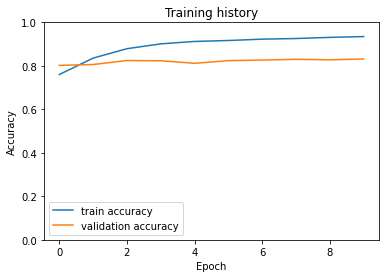

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#Evaluation

In [ ]:
test_acc, _ = eval_model(model,hate_test_dataload,loss_fn,device,len(hate_test))
test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

0.5528619528619529

In [ ]:
def get_predictions(model,data_loader):
  model = model.eval()

  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _,preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return tweet_texts, predictions, prediction_probs, real_values


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  hate_test_dataload
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    not-hate       0.90      0.26      0.40      1718
        hate       0.48      0.96      0.64      1252

    accuracy                           0.55      2970
   macro avg       0.69      0.61      0.52      2970
weighted avg       0.72      0.55      0.50      2970



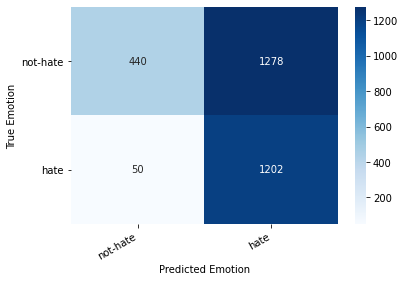

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Emotion')
  plt.xlabel('Predicted Emotion');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
show_confusion_matrix(df_cm)